In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Qobj, basis, mesolve, ket2dm, Options
from joblib import Parallel, delayed, parallel
from tqdm.auto import tqdm
import contextlib

/home/pabolojo/miniconda3/envs/quantum/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def omega(times, tau, sigma, omega0, sign=1):
    tf = times[-1]
    return omega0 * np.exp(-(times - tf/2 - sign*tau)**2 / (sigma**2))

def omega_12g(times, tau, sigma, omega0):
    return omega(times, tau, sigma, omega0)

def omega_23g(times, tau, sigma, omega0):
    return omega(times, tau, sigma, omega0, -1)

def CTAP_pulses(time_max, tau, sigma, omega0):
    if time_max == 0:
        return np.zeros(1000), np.zeros(1000)

    times = np.linspace(0, time_max, 1000)

    omega12 = omega_12g(times, tau, sigma, omega0)
    omega23 = omega_23g(times, tau, sigma, omega0)

    return omega12, omega23

In [17]:
def auxiliar_chi(times):
    tf = times[-1]
    t_prime = times / tf
    
    return np.pi * t_prime / 2 - 1 / 3 * np.sin(2 * np.pi * t_prime) + 1 / 24 * np.sin(4 * np.pi * t_prime)

def auxiliar_eta(d_chi, alpha_0):
    return np.arctan(d_chi / alpha_0)

def STA_pulses(time_max, alpha_0):
    """STA pulses based on IE and a Rutinger 1-3 trajectory."""
    if time_max == 0:
        return np.zeros(1000), np.zeros(1000)
    
    times = np.linspace(0, time_max, 1000)
    chi = auxiliar_chi(times)
    d_chi = np.gradient(chi, times)
    
    eta = auxiliar_eta(d_chi, alpha_0)
    d_eta = np.gradient(eta, times)
    
    Omega_12 = np.cos(chi) * d_eta + np.sin(chi) * d_chi / (np.tan(eta) + 1e-15)
    Omega_23 = -np.sin(chi) * d_eta + np.cos(chi) * d_chi / (np.tan(eta) + 1e-15)
    
    return Omega_12, Omega_23

In [18]:
def hamiltonian_factory(Delta, Omega12, Omega23):
    """Hamiltonian for a three level system in a Lambda-configuration, with two-photon detuning equals to 0."""
    H = np.zeros((3, 3), dtype=complex)
    
    H[0, 0:] = [0, Omega12, 0]
    H[1, 1:] = [Delta, Omega23]
    H[2, 2:] = [0]
    
    H += H.T.conjugate() - np.diag(np.diag(H))
    return Qobj(H)

In [19]:
def solve_dynamics(time_max, Gamma, Delta, pulse1, pulse2):
    """Solve the dynamics under CTAP and pure dephasing."""
    psi_0 = basis(3, 0)
    times = np.linspace(0, time_max, 1000)
    
    if time_max == 0:
        return 0, np.array(ket2dm(psi_0)).reshape((1, 3, 3))
    
    c_ops = [np.array([1, -1, 0]) * np.sqrt(Gamma / 2), np.array([1, 1, -2]) * np.sqrt(Gamma / 6)]
    c_ops = [Qobj(np.diag(op)) for op in c_ops]

    H_0 = hamiltonian_factory(Delta, 0, 0)
    H_12 = [hamiltonian_factory(0, 1, 0), pulse1]
    H_23 = [hamiltonian_factory(0, 0, 1), pulse2]
    H_total = [H_0, H_12, H_23]
    
    #opts = Options(nsteps=time_max*50000)

    rho_t = mesolve(H_total, psi_0, times, c_ops=c_ops).states
    
    return times, np.array(rho_t)

def compute_populations(time_max, Gamma, Delta, pulses):
    """Obtain the population for each level after a CTAP."""
    time, rho_t = solve_dynamics(time_max, Gamma, Delta, pulses[0], pulses[1])
    populations = np.diagonal(rho_t, axis1=1, axis2=2).real
    return populations[-1]

In [20]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar."""
    class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = parallel.BatchCompletionCallBack
    parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [7]:
Delta = 0
Omega_max = 6

In [29]:
n_tmax = 50
n_Gamma = 50
n_total = n_tmax * n_Gamma

Gamma_vec_com = np.linspace(0, 10, n_Gamma) * Omega_max / (2 * np.pi)

In [30]:
# CTAP

t_max = 120

tmax_vec = np.linspace(0, t_max, n_tmax) * 2 * np.pi / Omega_max

tmax_vec_CTAP, Gamma_vec = [x.flatten() for x in np.meshgrid(tmax_vec, Gamma_vec_com)]

In [31]:
# Solve in paralel the CTAP transfer

with tqdm_joblib(tqdm(range(n_total), desc="Computing transfer")) as pbar:
    CTAP_populations = Parallel(n_jobs=-1)(delayed(compute_populations)(tmax_vec_CTAP[j], Gamma_vec[j],
                                                                   Delta, CTAP_pulses(tmax_vec_CTAP[j], tmax_vec_CTAP[j]/6, tmax_vec_CTAP[j]/6, Omega_max)) for j in range(n_total))

CTAP_populations = np.array(CTAP_populations).reshape(n_Gamma, n_tmax, 3)

Computing transfer: 100%|██████████| 2500/2500 [00:26<00:00, 94.31it/s] 


In [33]:
# STA

alpha_0 = 40
t_max = 8

tmax_vec = np.linspace(0, t_max, n_tmax) * 2 * np.pi / Omega_max

tmax_vec_STA, Gamma_vec = [x.flatten() for x in np.meshgrid(tmax_vec, Gamma_vec_com)]

In [34]:
# Solve in paralel the STA transfer

with tqdm_joblib(tqdm(range(n_total), desc="Computing transfer")) as pbar:
    STA_populations = Parallel(n_jobs=-1)(delayed(compute_populations)(tmax_vec_STA[j], Gamma_vec[j],
                                                                   Delta, STA_pulses(tmax_vec_STA[j], alpha_0)) for j in range(n_total))
    
STA_populations = np.array(STA_populations).reshape(n_Gamma, n_tmax, 3)

Computing transfer: 100%|██████████| 2500/2500 [00:25<00:00, 97.78it/s] 


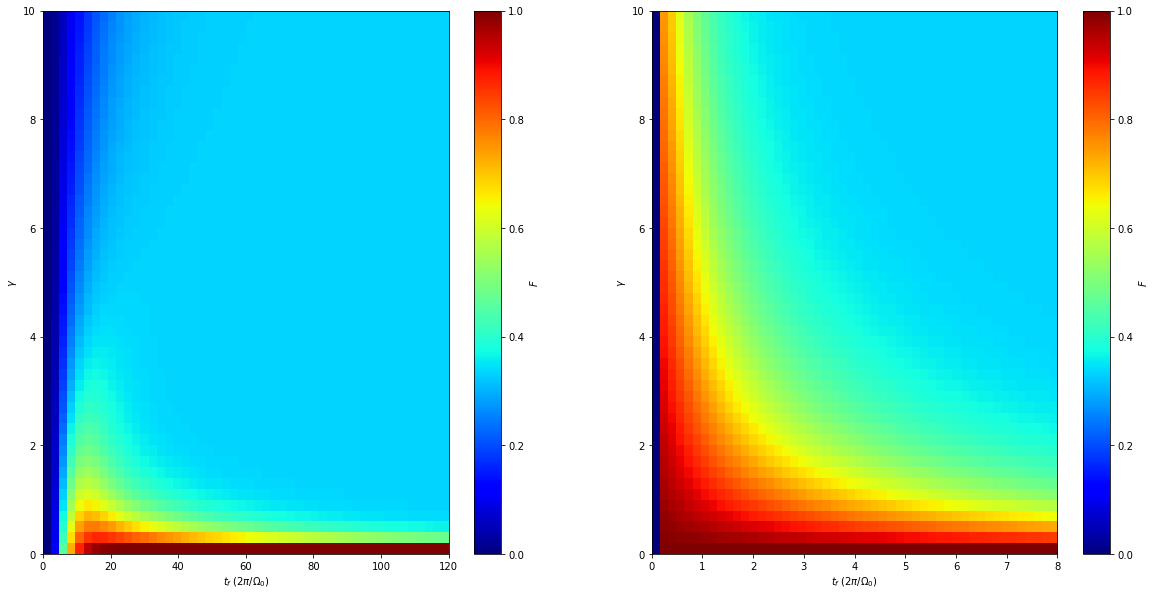

In [35]:
# Plot the results

fig, axs = plt.subplots(1, 2, figsize=(20,10))

im = axs[0].imshow(CTAP_populations[:, :, 2], origin='lower', aspect='auto', vmin=0, vmax=1, cmap='jet',
                    extent=[min(tmax_vec_CTAP) / (2*np.pi / Omega_max), max(tmax_vec_CTAP) / (2*np.pi / Omega_max),
                            min(Gamma_vec) / (Omega_max / (2 * np.pi)), max(Gamma_vec) / (Omega_max / (2 * np.pi))],
                    interpolation='None')

cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel(r'$F}$')

im = axs[1].imshow(STA_populations[:, :, 2], origin='lower', aspect='auto', vmin=0, vmax=1, cmap='jet',
                    extent=[min(tmax_vec_STA) / (2*np.pi / Omega_max), max(tmax_vec_STA) / (2*np.pi / Omega_max),
                            min(Gamma_vec) / (Omega_max / (2 * np.pi)), max(Gamma_vec) / (Omega_max / (2 * np.pi))],
                    interpolation='None')

cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel(r'$F$')

[ax.set_xlabel(r'$t_f\;(2\pi/\Omega_0)$') for ax in axs];
[ax.set_ylabel(r'$\gamma$') for ax in axs];